<a href="https://colab.research.google.com/github/newu2012/ComputerVisionCourse/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B8/lab3_fcnn_in_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование нейронной сети в пакете NumPy
---

### The idea was inspired by
https://github.com/SkalskiP/ILearnDeepLearning.py

following the link below you may play with th neural network constructor 
http://playground.tensorflow.org/

###  Импорт необходимых функций

In [1]:
import numpy as np
from IPython.display import Image

In [2]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm


from sklearn.metrics import accuracy_score

### Создание датасета

###  настройки

In [3]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

In [4]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.1, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

X = X.T
X_train = X_train.T
X_test = X_test.T

y = y.T
y_train = y_train.T
y_test = y_test.T


### Вспомогательная функция постройки изображения

In [5]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None):

    plt.figure(figsize=(8,6))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=plt.cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap=plt.cm.Greys, vmin=0, vmax=.6)
        
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.Spectral, edgecolors='k')
    if(file_name):
        plt.savefig(file_name)
        plt.close()


### Визуализация данных

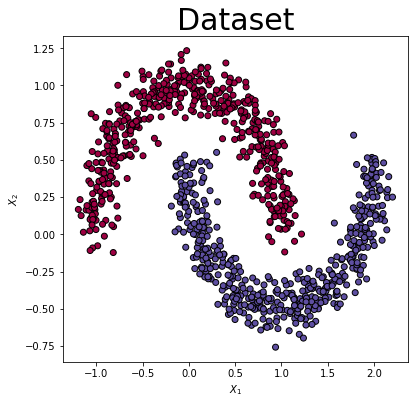

In [6]:
make_plot(X.T, y, "Dataset")


## Описание архитектуры 
номер слоя, название, входная и выходная размерность, функция активации

In [7]:
NN_ARCHITECTURE =  [
        {"N":0, "Name":"input",  "input_dim": None,  "output_dim": 2, "activation": ""},
        {"N":1, "Name":"hiden2", "input_dim": 2,  "output_dim": 25, "activation": "relu"},
        {"N":2, "Name":"hiden3", "input_dim": 25, "output_dim": 50, "activation": "relu"},
        {"N":3, "Name":"hiden4", "input_dim": 50, "output_dim": 50, "activation": "relu"},
        {"N":4, "Name":"hiden5", "input_dim": 50, "output_dim": 25, "activation": "relu"},
        {"N":5, "Name":"output", "input_dim": 25, "output_dim": 1,  "activation": "sigmoid"}
      ]




## Функция инициализации слоев сети

The next one step is to create and initialize the network weights

In [8]:
def init_layers(nn_architecture, seed = 99):
    
    # random seed initiation for pseudo-random weights initialization
    np.random.seed(seed)
    
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for layer_idx in range(number_of_layers):
        
        # we number network layers from 1
        if layer_idx>0:
            layer = nn_architecture[layer_idx]
            
            # extracting the number of units in layers
            layer_input_size  = layer["input_dim"]
            layer_output_size = layer["output_dim"]
        
            # initiating the values of the W matrix            
            # and vector b for subsequent layers
            params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1
            params_values['activation' + str(layer_idx)] = layer["activation"]
        
    return params_values, number_of_layers-1


In [9]:
# TEST
params_values, nOfLayers = init_layers(nn_architecture = NN_ARCHITECTURE)

print(params_values.keys())
print(params_values["W2"].shape)
print(params_values["b2"].shape)

print(params_values["W1"].shape)
print(params_values["b1"].shape)


dict_keys(['W1', 'b1', 'activation1', 'W2', 'b2', 'activation2', 'W3', 'b3', 'activation3', 'W4', 'b4', 'activation4', 'W5', 'b5', 'activation5'])
(50, 25)
(50, 1)
(25, 2)
(25, 1)


## Activation functions  СОЗДАНИЕ ФУНКЦИИ АКТИВАЦИИ

**SIGMOID**

$$ \sigma (z) = \frac{1}{1+\exp[-z]}$$

**ReLU**

$$ ReLU (z) = \max(0,z) $$


* **где**
    * $z = W^T X+b^T$
    * W вектор весов
    * X данные на входе
    * b смещение
    

In [10]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)


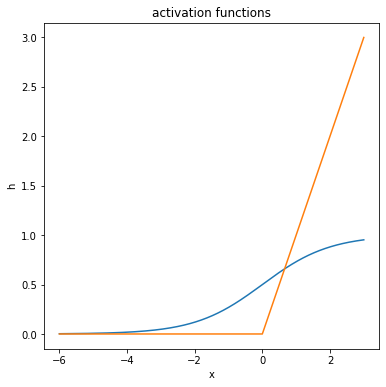

In [11]:
# VIZUALIZATION 
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
x = np.linspace(-6,3,1000)
plt.plot(x,sigmoid(x))
plt.plot(x,relu(x))
plt.title('activation functions')
plt.xlabel('x')
plt.ylabel('h')
plt.show()


## Прямое распространение ошибки в одном слое

$$ Z_l = W_l^T \cdot {O_{l-1} + b_l^T} $$

$$ O_l = f_l (Z_l) $$

* **где**:
    * $O$ выход предыдущего слоя ($O=X$ для 1 слоя)
    * $f$ функция активации
    * $Z$ линейная часть перцептрона
    * $W$ вектор весов
    * $b$ вектор смещений
    

#### В нашем случае выборка и веса сразу транспонированы

$$ Z_l = W_{tr_{l-1}} \cdot {O_{tr_{l-1}} + b_l} $$

* где $O_{tr_{l-1}}$ сразу транспонирован
    ($O_{tr_{l-1}}=X^T$ 1 слой))
* $W_{tr_{l-1}}$ вектор весов в нашем случае


In [12]:
def layer_forward_propagation(inputs, W_curr, b_curr, activation="relu"):
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, inputs) + b_curr   
    
    output = activation_func(Z_curr)

    # return of calculated activation A and the intermediate Z matrix
    return output

In [363]:
inputs  = X
weights = params_values['W1']
bias    = params_values['b1']

outputs = layer_forward_propagation(inputs, weights, bias, activation="relu")


In [364]:
inputs  = outputs
weights = params_values['W2']
bias    = params_values['b2']

outputs = layer_forward_propagation(inputs, weights, bias, activation="sigmoid")


## Процедура полного прямого распространения 

In [310]:
def forward_propagation(X, params_values, nOfLayers):
    # X vector is the activation for layer 0 
    outputs = X
    
    # iteration over network layers
    # we number network layers from 1
    for layer_idx in range(1,nOfLayers+1,1):

        # transfer the activation from the previous iteration
        inputs = outputs
        
        # extraction of the activation function for the current layer
        print(layer_idx)
        act_fun = params_values["activation"+ str(layer_idx)]
        W_curr  = params_values["W" + str(layer_idx)]
        b_curr  = params_values["b" + str(layer_idx)]
        
        # calculation of activation for the current layer        
        outputs = layer_forward_propagation(inputs, W_curr, b_curr, act_fun)
        
        params_values["inputs" + str(layer_idx)]= inputs
              
    # return of prediction vector and a dictionary containing intermediate values
    return outputs, params_values

In [373]:
# TEST
y_hat, params_values = forward_propagation(X, params_values, nOfLayers)
print(y_hat.shape)
print(params_values.keys())

KeyError: ignored

## Расчет функции потерь (ошибки)

**для logloss функции** 
$$ L = ylog {\hat y} - (1-y)log {[1 - \hat y]}$$

In [17]:
def get_cost_value(Y_hat, Y):
    
    # number of examples
    m = Y_hat.shape[1]
    
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    
    return np.squeeze(cost)

## Расчет точности 

#### функция для определения класса

In [18]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs, threshold=0.5):
    
    probs_ = np.copy(probs)
    probs_[probs_ > threshold] = 1
    probs_[probs_ <= threshold] = 0
    
    return probs_

In [19]:
y_hat_ = convert_prob_into_class(y_hat)
print(y_hat_)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

##### функция для оперделения точности

In [20]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [21]:
print(get_accuracy_value(y_hat, y))

0.5




## Процедура обратного распространения ошибки


Нейронные сети могут быть рассмотрены как обобщение нелинейной регрессии.

обратное распространение ошибки - алгоритм отпимизации градиентного спуска для многослойных нейронных сетей
  
**Проблема**
  
  $$ \hat y = f\big(w_{last}^TO_{last-1}\big)= f\big(w_{last}f(w_{last-1}^TO_{last-2})\big)=...=f\big(w_{last}^Tf(...f(w_1^TX))\big)$$
  
 для большого числа слоев сложно оптимизировать функцию за один раз


**расмотрим последний слой сети**
  
используя т.н. правило цепочного дифференцирования
  
  $$\frac{d z(y(x))}{ d x} =\frac{\partial z(y(x))} {\partial y} \frac{\partial y(x)} {\partial x }  $$

**Тогда:**

$$\Delta W_{last} \leftarrow {\nabla_{w_{last}}} E(y| \hat y) =\frac{1}{m} \frac{\partial L }{\partial W_{last}} $$

$$\frac{\partial L }{\partial W_{last}}= \frac{\partial L }{\partial \hat y} \frac{\partial \hat y }{\partial Z_{last}}  \frac{\partial Z_{last} }{\partial  W_{last}} $$

$$\frac{\partial L }{\partial W_{last}}= \big(e * \frac{\partial f(z)}{\partial z} \big)  O_{last-1}^T $$

* **где**
    * $e = {\partial L }/{\partial \hat y}$ градиент ошибки
    * $\hat y = f(Z_{last}) = f(W_l^T O_{last-1})$ выход последнего слоя 
    * $ Z_{last} = W_{last}^T O_{last-1} $ линейная часть перцептрона
    * $ O_{last-1} $ вход последнего слоя (выход предпоследнего)
    * $W_{last} $ вектор весов
    * $*$ поэлементное произведение



### Производные функций активации

**sigmoid**
$$\frac{\partial \sigma(z)}{\partial z} =\sigma(z)(1-\sigma(z))$$

**ReLU**
$$\frac{\partial ReLU(z)}{\partial z} = 1 if[z>0] or 0 if[z<= 0] $$

In [22]:
def sigmoid_derev( Z):
    sig = sigmoid(Z)
    return sig * (1 - sig)

def relu_derev( Z):
    dZ = np.ones(Z.shape)
    dZ[Z <= 0] = 0
    return dZ


### производная функции потерь

**logloss функция ошбики (потерь)** 
$$ L = ylog {\hat y} - (1-y)log {[1 - \hat y]}$$

#### производаня функции ошбики (потерь)
$$ e = \frac{\partial L}{\partial \hat y} = -\frac {y-\hat y}{\hat y (1-\hat y)}$$

In [23]:
def loss_derev(Y,Y_hat):
    e_next = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    return e_next

### Градиент для предпоследнего слоя



$$\Delta W_{last-1} \leftarrow {\nabla_{w_{last-1}}} E(y| \hat y) = \frac{1}{m}\frac{\partial L }{\partial W_{last-1}} $$

$$\frac{\partial L }{\partial W_{last-1}}= \frac{\partial L }{\partial \hat y} \frac{\partial \hat y }{\partial Z_{last}} \frac{\partial Z_{last} }{\partial Z_{last-1}}  \frac{\partial Z_{last-1} }{\partial  W_{last}} $$

$$\frac{\partial L }{\partial W_{last-1}}= \big(e_{last-1} * \frac{\partial f(z_{last-1})}{\partial z_{last-1}} \big)  O_{last-2}^T $$

* **где **
    * $$e_{last-1} = W_{last}^Te* \frac{\partial f(z_{last})}{\partial z_{last}} $$  
    градиент функции ошибки на last-1 слое



### Для произвольного слоя


$$\Delta W_{l} \leftarrow {\nabla_{w_{l}}} E(y| \hat y) =\frac{1}{m} \frac{\partial L }{\partial W_{l}} $$

$$\frac{\partial L }{\partial W_{l}}= \frac{\partial L }{\partial \hat y} \frac{\partial \hat y }{\partial Z_{last}} \frac{\partial Z_{last} }{\partial Z_{last-1}} ... \frac{\partial Z_{l} }{\partial  W_{l+1}} $$

$$\frac{\partial L }{\partial W_{l}}= \bigg(e_{l} * \frac{\partial f(z_{l})}{\partial z_{l}} \bigg)  O_{l-1}^T $$

* **где**
    * $e_{l} = W_{l+1}^Te_{l+1}* \frac{\partial f(z_{l+1})}{\partial z_{l+1}}$ градиент функции ошибки на l слое
  


## Таким образом в наших обозначениях

**Другими словами**:    

$$\Delta W_l \leftarrow \nabla_{w_l} E = \frac{1}{m}\bigg(e_l*\frac{\partial f(Z_l)}{\partial [{weights}_l]}\bigg)input^T_l$$    

* где 
    * $e_l = {weights}_{l+1}e_{l+1}*\frac{\partial f(Z_{l+1})}{\partial [{weights}_{l+1}]}$
    * $Z_l = {weights}_l * input_l+bias$

**Также можно отдельно рассмотреть градиент смещения**

$$\Delta b_l = \sum_i^N{\big[e_l*\frac{\partial f(z)}{\partial z}}\big] $$


### Теперь можно обновить веса и смещения


$$W_{l} = W_{l} - \eta \nabla_{W_l} E $$

$$b_{l} = b_{l} - \eta \nabla_{b_l} E $$


In [24]:
def layer_backward_propagation(e, W_curr, b_curr, inputs, activation="relu"):
    # number of examples
    m = inputs.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_derev
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_derev
    else:
        raise Exception('Non-supported activation function')
    
    Z_curr = np.dot(W_curr, inputs) + b_curr
    
    # calculation of the activation function derivative
    e_dfdz = e*backward_activation_func(Z_curr)
    
    # derivative of the matrix W
    grad_W = np.dot(e_dfdz, inputs.T) / m
    
    # derivative of the vector b
    grad_b = np.sum(e_dfdz, axis=1, keepdims=True) / m
    
    # derivative of the matrix A_prev
    e_next = np.dot(W_curr.T, e_dfdz)
      
    return e_next, grad_W, grad_b


## Full backward propagation
## Полная процедура обратного распространения   

In [25]:
def backward_propagation(Y_hat, Y, params_values, step, nOfLayers):
    
    # number of examples
    m = Y.shape[1]
    
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    e_next = loss_derev(Y,Y_hat)
    
    for layer_idx in range(nOfLayers,0,-1):
             
        W_curr  = params_values["W" + str(layer_idx)]
        b_curr  = params_values["b" + str(layer_idx)]
        inputs  = params_values["inputs" + str(layer_idx)]
        act_fun = params_values["activation" + str(layer_idx)]
        
        e_next, grad_W, grad_b = layer_backward_propagation(e_next, W_curr, b_curr, inputs, act_fun)
        
        params_values["W" + str(layer_idx)] -= step * grad_W        
        params_values["b" + str(layer_idx)] -= step * grad_b
    
    return params_values

## Putting things together
## Полная процедура тренеровки

In [26]:
def train(X, Y, nn_architecture, epochs, step, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values,nOfLayers = init_layers(nn_architecture, seed = 2)
     
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        
        # forward propagation stage
        Y_hat, params_values = forward_propagation(X, params_values, nOfLayers)
        
        # calculating metrics and saving them in history
        cost     = get_cost_value(Y_hat, Y)        
        accuracy = get_accuracy_value(Y_hat, Y)
        
        cost_history.append(cost)
        accuracy_history.append(accuracy)
        
        # backward - calculating gradient stage
        params_values = backward_propagation(Y_hat, Y, params_values, step, nOfLayers)

        if(i % (epochs/10) == 0):
            if(verbose):
                print("Iteration: {:03} - loss: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

### Let's put our model to the test

### тест процедуры

In [27]:
y_y = np.transpose(y_train.reshape((y_train.shape[0], 1)))
print(y_y.shape)
# Training
params_values = train((X_train), y_y, NN_ARCHITECTURE, 900, 0.1,True)

(1, 900)
Iteration: 000 - loss: 0.69366 - accuracy: 0.50444
Iteration: 090 - loss: 0.69138 - accuracy: 0.50444
Iteration: 180 - loss: 0.68379 - accuracy: 0.85111
Iteration: 270 - loss: 0.55839 - accuracy: 0.84778
Iteration: 360 - loss: 0.25250 - accuracy: 0.89000
Iteration: 450 - loss: 0.21733 - accuracy: 0.89667
Iteration: 540 - loss: 0.18161 - accuracy: 0.91111
Iteration: 630 - loss: 0.08468 - accuracy: 0.97111
Iteration: 720 - loss: 0.02697 - accuracy: 0.99556
Iteration: 810 - loss: 0.01407 - accuracy: 0.99889




### Оценка точности 

In [28]:
def predict(inputs, params_values, nOfLayers):
    Y_hat,_ = forward_propagation(inputs, params_values, nOfLayers)
    return Y_hat

In [29]:
Y_hat = predict(X_test, params_values, nOfLayers)

print(Y_hat.shape)

print(get_accuracy_value(Y_hat, y_test))

(1, 100)
1.0




## Давайте посмотрим как это выглядит

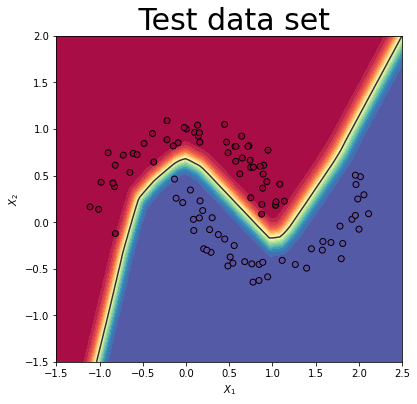

In [30]:
plot_title = " Test data set"

# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

prediction_probs = predict(grid_2d.T, params_values, nOfLayers)

prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    
make_plot(X_test.T, y_test.T, plot_title, XX=XX, YY=YY, preds=prediction_probs)




#### напишим процедуру предсказания класса по значениям X1 и X2

In [31]:
def predict_class(inputs, params_values, nOfLayers):
    
    Y_hat = predict(inputs, params_values, nOfLayers)
    Y_hat_ = convert_prob_into_class(Y_hat)
    
    return np.array(Y_hat_, dtype='int32')

In [32]:
X1 = 1.5
X2 = 1.5
Y_hat  = predict_class(np.array([[X1],[X2]]), params_values, nOfLayers)
print(Y_hat)

X1 = 0
X2 = 0
Y_hat  = predict_class(np.array([[X1],[X2]]), params_values, nOfLayers)
print(Y_hat)



[[0]]
[[1]]



## Эксперименты с архитектурами



### случай недообучения, когда мало слоев  (underfitting )

In [33]:
NN_ARCHITECTURE =  [
        {"N":0, "Name":"input",  "input_dim": None,  "output_dim": 2, "activation": ""},
        {"N":1, "Name":"hiden1", "input_dim": 2,  "output_dim": 7, "activation": "relu"},    
        {"N":2, "Name":"output", "input_dim": 7, "output_dim": 1,  "activation": "sigmoid"}
     ]

In [34]:
y_y = np.transpose(y_train.reshape((y_train.shape[0], 1)))
print(y_y.shape)
# Training
params_values = train((X_train), y_y, NN_ARCHITECTURE, 10000, 0.11,True)

(1, 900)
Iteration: 000 - loss: 0.69594 - accuracy: 0.49556
Iteration: 1000 - loss: 0.22926 - accuracy: 0.89111
Iteration: 2000 - loss: 0.21135 - accuracy: 0.89000
Iteration: 3000 - loss: 0.20852 - accuracy: 0.88889
Iteration: 4000 - loss: 0.20780 - accuracy: 0.88889
Iteration: 5000 - loss: 0.20745 - accuracy: 0.89000
Iteration: 6000 - loss: 0.20724 - accuracy: 0.89000
Iteration: 7000 - loss: 0.20709 - accuracy: 0.89000
Iteration: 8000 - loss: 0.20698 - accuracy: 0.88778
Iteration: 9000 - loss: 0.20688 - accuracy: 0.88778


In [35]:
Y_hat = predict(X_test, params_values, len(NN_ARCHITECTURE)-1)

print(Y_hat.shape)

print(get_accuracy_value(Y_hat, y_test))

(1, 100)
0.88


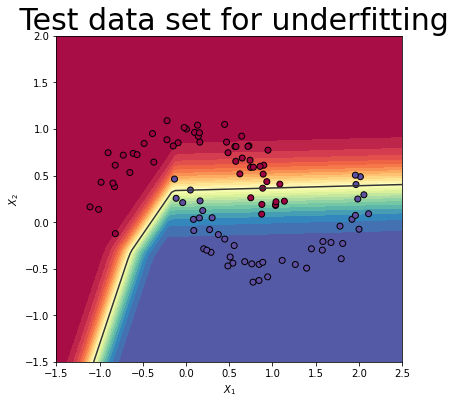

In [36]:
plot_title = " Test data set for underfitting"

# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

prediction_probs = predict(grid_2d.T, params_values, len(NN_ARCHITECTURE)-1)

prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    
make_plot(X_test.T, y_test.T, plot_title, XX=XX, YY=YY, preds=prediction_probs)



### случай, когда много слоев и параметров
### Возможно переобучение



In [37]:
NN_ARCHITECTURE =  [
        {"N":0, "Name":"input",  "input_dim": 2,   "output_dim":2,    "activation": ""},
        {"N":1, "Name":"hiden1", "input_dim": 2,   "output_dim":100,  "activation": "relu"},
        {"N":2, "Name":"hiden2", "input_dim": 100, "output_dim":100,  "activation": "relu"},
        {"N":3, "Name":"hiden3", "input_dim": 100, "output_dim":100,  "activation": "relu"},
        {"N":4, "Name":"hiden4", "input_dim": 100, "output_dim":100,  "activation": "relu"},
        {"N":5, "Name":"hiden5", "input_dim": 100, "output_dim":100,  "activation": "relu"},
        {"N":6, "Name":"hiden6", "input_dim": 100, "output_dim":100,  "activation": "relu"},
        {"N":7, "Name":"hiden7", "input_dim": 100, "output_dim":100,  "activation": "relu"},
        {"N":8, "Name":"hiden8", "input_dim": 100, "output_dim":100,  "activation": "relu"},    
        {"N":9, "Name":"output", "input_dim": 100, "output_dim": 1,   "activation": "sigmoid"}
     ]

In [38]:
y_y = np.transpose(y_train.reshape((y_train.shape[0], 1)))
print(y_y.shape)
# Training
params_values = train((X_train), y_y, NN_ARCHITECTURE, 2000, 0.1, True)

(1, 900)
Iteration: 000 - loss: 0.69878 - accuracy: 0.49556
Iteration: 200 - loss: 0.01553 - accuracy: 0.99778
Iteration: 400 - loss: 0.00150 - accuracy: 1.00000
Iteration: 600 - loss: 0.00067 - accuracy: 1.00000
Iteration: 800 - loss: 0.00042 - accuracy: 1.00000
Iteration: 1000 - loss: 0.00030 - accuracy: 1.00000
Iteration: 1200 - loss: 0.00023 - accuracy: 1.00000
Iteration: 1400 - loss: 0.00019 - accuracy: 1.00000
Iteration: 1600 - loss: 0.00016 - accuracy: 1.00000
Iteration: 1800 - loss: 0.00013 - accuracy: 1.00000


In [39]:
Y_hat = predict(X_test, params_values, len(NN_ARCHITECTURE)-1)

print(Y_hat.shape)

print(get_accuracy_value(Y_hat, y_test))

(1, 100)
1.0


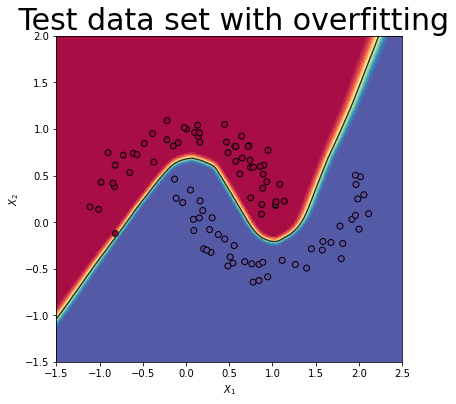

In [40]:
plot_title = " Test data set with overfitting"

# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

prediction_probs = predict(grid_2d.T, params_values, len(NN_ARCHITECTURE)-1)

prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    
make_plot(X_test.T, y_test.T, plot_title, XX=XX, YY=YY, preds=prediction_probs)

# Упражнения. 

Исследовать как нейронная сеть ведет себя в случае XOR проблемы

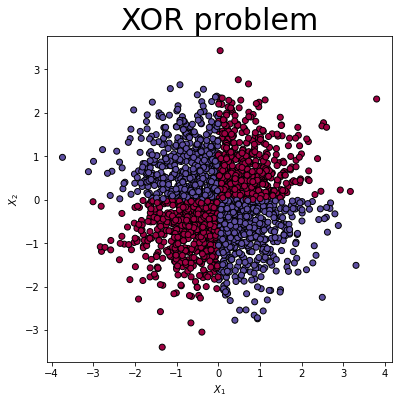

In [403]:
rng = np.random.RandomState(0)
X = rng.randn(2000, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X = X.T
X_train = X_train.T
X_test = X_test.T

y = y.T
y_train = y_train.T
y_test = y_test.T

make_plot(X.T, y.T, 'XOR problem')

In [124]:
NN_ARCHITECTURE =  [
        {"N":0, "Name":"input",  "input_dim": None,  "output_dim": 2, "activation": ""},
        {"N":1, "Name":"hiden2", "input_dim": 2,  "output_dim": 25, "activation": "relu"},
        {"N":2, "Name":"hiden3", "input_dim": 25, "output_dim": 50, "activation": "relu"},
        {"N":3, "Name":"hiden4", "input_dim": 50, "output_dim": 50, "activation": "relu"},
        {"N":4, "Name":"hiden5", "input_dim": 50, "output_dim": 25, "activation": "relu"},
        {"N":5, "Name":"output", "input_dim": 25, "output_dim": 1,  "activation": "sigmoid"}
      ]

In [127]:
y_y = np.transpose(y_train.reshape((y_train.shape[0], 1)))
print(y_y.shape)
# Training
params_values = train((X_train), y_y, NN_ARCHITECTURE, 1000, 0.1, True)

(1, 1800)
Iteration: 000 - loss: 0.69299 - accuracy: 0.49833
Iteration: 100 - loss: 0.69214 - accuracy: 0.61444
Iteration: 200 - loss: 0.69090 - accuracy: 0.62778
Iteration: 300 - loss: 0.68751 - accuracy: 0.66833
Iteration: 400 - loss: 0.67216 - accuracy: 0.71667
Iteration: 500 - loss: 0.51323 - accuracy: 0.86722
Iteration: 600 - loss: 0.10379 - accuracy: 0.99833
Iteration: 700 - loss: 0.09257 - accuracy: 0.95056
Iteration: 800 - loss: 0.06684 - accuracy: 0.96333
Iteration: 900 - loss: 0.06663 - accuracy: 0.96278


In [128]:
Y_hat = predict(X_test, params_values, nOfLayers)

print(Y_hat.shape)

print(get_accuracy_value(Y_hat, y_test))

(1, 200)
0.98


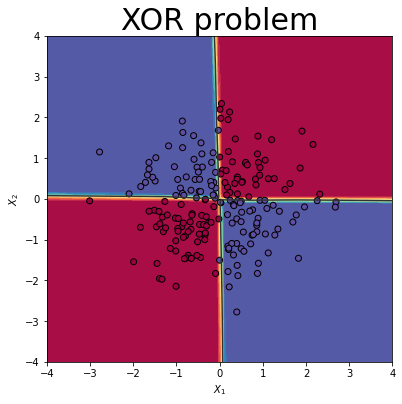

In [129]:
plot_title = "XOR problem"

# boundary of the graph
GRID_X_START = -4
GRID_X_END = 4
GRID_Y_START = -4
GRID_Y_END = 4

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
prediction_probs = predict(grid_2d.T, params_values, len(NN_ARCHITECTURE)-1)
prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
make_plot(X_test.T, y_test.T, plot_title, XX=XX, YY=YY, preds=prediction_probs)

### Попробывать заменить функцию потерь на другую, например на L2:
$$ L(y|\hat y) = [y-\hat y][y-\hat y]^T $$
$$ \frac{\partial L(y|\hat y)}{\partial \hat y} = -2[y-\hat y] $$

In [216]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    cost = np.squeeze(cost)
    #print(cost)
    return cost

In [219]:
# new
def get_cost_value(Y_hat, Y):
    cost = np.dot(Y - Y_hat, (Y - Y_hat).T)
    cost = np.squeeze(cost)
    #print(cost)
    return cost

In [131]:
y_y = np.transpose(y_train.reshape((y_train.shape[0], 1)))
print(y_y.shape)
# Training
params_values = train((X_train), y_y, NN_ARCHITECTURE, 1000, 0.1, True)

(1, 1800)
Iteration: 000 - loss: 449.85742 - accuracy: 0.49833
Iteration: 100 - loss: 449.09171 - accuracy: 0.61444
Iteration: 200 - loss: 447.98045 - accuracy: 0.62778
Iteration: 300 - loss: 444.92262 - accuracy: 0.66833
Iteration: 400 - loss: 431.12610 - accuracy: 0.71667
Iteration: 500 - loss: 293.63061 - accuracy: 0.86722
Iteration: 600 - loss: 43.36327 - accuracy: 0.99833
Iteration: 700 - loss: 52.70954 - accuracy: 0.95056
Iteration: 800 - loss: 37.90790 - accuracy: 0.96333
Iteration: 900 - loss: 39.60147 - accuracy: 0.96278


In [132]:
Y_hat = predict(X_test, params_values, nOfLayers)

print(Y_hat.shape)

print(get_accuracy_value(Y_hat, y_test))

(1, 200)
0.98


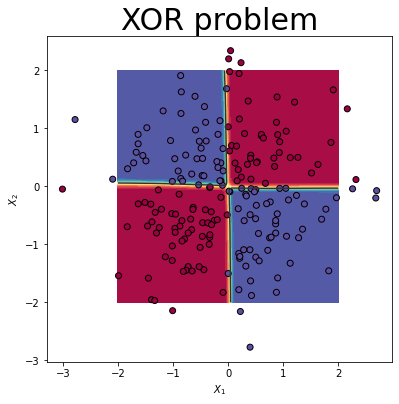

In [133]:
plot_title = "XOR problem"

# boundary of the graph
GRID_X_START = -2
GRID_X_END = 2
GRID_Y_START = -2
GRID_Y_END = 2

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
prediction_probs = predict(grid_2d.T, params_values, len(NN_ARCHITECTURE)-1)
prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
make_plot(X_test.T, y_test.T, plot_title, XX=XX, YY=YY, preds=prediction_probs)

### Попробывать обучение с другими функциями активации, например tanh :
$$ tanh(z) = \frac{e^Z-e^{-Z}}{e^Z+e^{-Z}}$$
$$ \frac{\partial tanh(z)}{\partial z} = 1-tanh^2(z)$$

####  $^*$! Примечание:  функция имеет диапазон значений от -1 до 1 и не может быть использована вместе с logloss 

In [49]:
def sigmoid_derev( Z):
    sig = sigmoid(Z)
    return sig * (1 - sig)

def relu_derev( Z):
    dZ = np.ones(Z.shape)
    dZ[Z <= 0] = 0
    return dZ

In [188]:
def tanh( Z):
    #value = np.tanh(Z)
    value = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    #print(value)
    return value

def tanh_derev( Z):
    value = 1 - np.square(tanh(Z))
    #print(value)
    return value

In [180]:
# new
def layer_forward_propagation(inputs, W_curr, b_curr, activation="tanh"):
    # selection of activation function

    #print(activation)
    if activation is "tanh":
        activation_func = tanh
    elif activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # calculation of the input value for the activation function
    #print(W_curr, '\n\n\n\n', inputs, '\n\n\n\n', b_curr, '\n\n\n\n')
    Z_curr = np.dot(W_curr, inputs) + b_curr   
    
    output = activation_func(Z_curr)

    # return of calculated activation A and the intermediate Z matrix
    return output

In [181]:
# new 
def layer_backward_propagation(e, W_curr, b_curr, inputs, activation="tanh"):
    # number of examples
    m = inputs.shape[1]
    
    # selection of activation function
    if activation is "tanh":
        backward_activation_func = tanh_derev
    elif activation is "relu":
        backward_activation_func = relu_derev
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_derev
    else:
        raise Exception('Non-supported activation function')
    
    Z_curr = np.dot(W_curr, inputs) + b_curr
    
    # calculation of the activation function derivative
    e_dfdz = e*backward_activation_func(Z_curr)
    
    # derivative of the matrix W
    grad_W = np.dot(e_dfdz, inputs.T) / m
    
    # derivative of the vector b
    grad_b = np.sum(e_dfdz, axis=1, keepdims=True) / m
    
    # derivative of the matrix A_prev
    e_next = np.dot(W_curr.T, e_dfdz)
      
    return e_next, grad_W, grad_b

In [409]:
NN_ARCHITECTURE =  [
        {"N":0, "Name":"input",  "input_dim": None,  "output_dim": 2, "activation": ""},
        {"N":1, "Name":"hiden1", "input_dim": 2,  "output_dim": 25, "activation": "tanh"},
        {"N":2, "Name":"hiden2", "input_dim": 25,  "output_dim": 25, "activation": "relu"},
        {"N":3, "Name":"output", "input_dim": 25, "output_dim": 1,  "activation": "sigmoid"}
      ]

In [410]:
y_y = np.transpose(y_train.reshape((y_train.shape[0], 1)))
print(y_y.shape)
# Training
params_values = train((X_train), y_y, NN_ARCHITECTURE, 1000, 0.1, True)

(1, 1800)
Iteration: 000 - loss: 450.04267 - accuracy: 0.48889
Iteration: 100 - loss: 446.11104 - accuracy: 0.77222
Iteration: 200 - loss: 433.95116 - accuracy: 0.83278
Iteration: 300 - loss: 386.01230 - accuracy: 0.84778
Iteration: 400 - loss: 244.74065 - accuracy: 0.90056
Iteration: 500 - loss: 118.06995 - accuracy: 0.95667
Iteration: 600 - loss: 73.71765 - accuracy: 0.98278
Iteration: 700 - loss: 54.88164 - accuracy: 0.99333
Iteration: 800 - loss: 44.56913 - accuracy: 0.99444
Iteration: 900 - loss: 37.99612 - accuracy: 0.99389


In [411]:
Y_hat = predict(X_test, params_values, nOfLayers)
print(Y_hat.shape)
print(get_accuracy_value(Y_hat, y_test))

(25, 200)
0.0


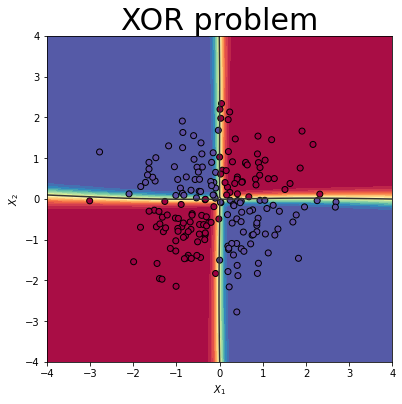

In [412]:
plot_title = "XOR problem"

# boundary of the graph
GRID_X_START = -4
GRID_X_END = 4
GRID_Y_START = -4
GRID_Y_END = 4

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
prediction_probs = predict(grid_2d.T, params_values, len(NN_ARCHITECTURE)-1)
prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
make_plot(X_test.T, y_test.T, plot_title, XX=XX, YY=YY, preds=prediction_probs)

### Подобрать конфигурацию сети, решающую проблему окружностей:


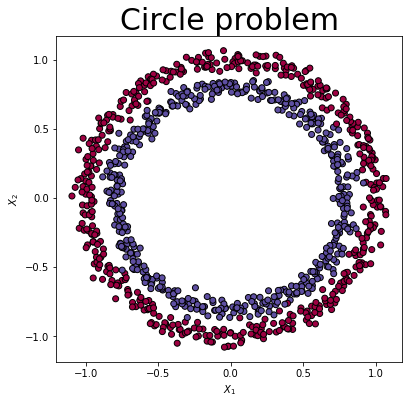

In [413]:
import sklearn
X,y = sklearn.datasets.make_circles(n_samples = N_SAMPLES, noise=0.04, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

X = X.T
X_train = X_train.T
X_test = X_test.T

y = y.T
y_train = y_train.T
y_test = y_test.T

make_plot(X.T, y.T, 'Circle problem')

In [424]:
# 0.99, 0.98556
NN_ARCHITECTURE =  [
        {"N":0, "Name":"input",  "input_dim": None,  "output_dim": 2, "activation": ""},
        {"N":1, "Name":"hiden1", "input_dim": 2,  "output_dim": 25, "activation": "tanh"},
        {"N":2, "Name":"hiden2", "input_dim": 25,  "output_dim": 25, "activation": "relu"},
        {"N":3, "Name":"output", "input_dim": 25, "output_dim": 1,  "activation": "sigmoid"}
      ]

In [425]:
params_values, nOfLayers = init_layers(nn_architecture = NN_ARCHITECTURE)
print(params_values.keys())

dict_keys(['W1', 'b1', 'activation1', 'W2', 'b2', 'activation2', 'W3', 'b3', 'activation3'])


In [426]:
y_y = np.transpose(y_train.reshape((y_train.shape[0], 1)))
print(y_y.shape)
# Training
params_values = train((X_train), y_y, NN_ARCHITECTURE, 3000, 0.1, True)

(1, 900)
Iteration: 000 - loss: 224.99369 - accuracy: 0.45000
Iteration: 300 - loss: 224.57530 - accuracy: 0.57222
Iteration: 600 - loss: 224.06407 - accuracy: 0.58444
Iteration: 900 - loss: 222.96549 - accuracy: 0.63667
Iteration: 1200 - loss: 220.39731 - accuracy: 0.59556
Iteration: 1500 - loss: 214.80498 - accuracy: 0.57778
Iteration: 1800 - loss: 202.98267 - accuracy: 0.67333
Iteration: 2100 - loss: 173.41954 - accuracy: 0.92667
Iteration: 2400 - loss: 112.61691 - accuracy: 0.97111
Iteration: 2700 - loss: 43.07827 - accuracy: 0.98556


In [427]:
Y_hat = predict(X_test, params_values, nOfLayers)
print(Y_hat.shape)
print(get_accuracy_value(Y_hat, y_test))

(1, 100)
0.99


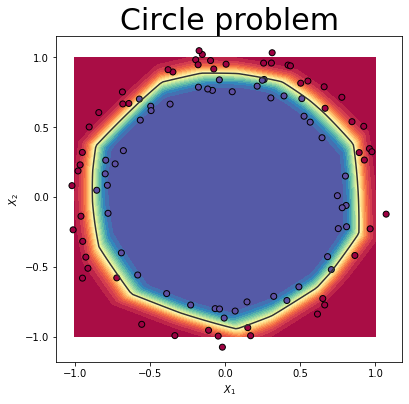

In [428]:
plot_title = "Circle problem"

# boundary of the graph
GRID_X_START = -1
GRID_X_END = 1
GRID_Y_START = -1
GRID_Y_END = 1

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
prediction_probs = predict(grid_2d.T, params_values, len(NN_ARCHITECTURE)-1)
prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
make_plot(X_test.T, y_test.T, plot_title, XX=XX, YY=YY, preds=prediction_probs)

### Попробывать подобрать сеть для следующей проблемы

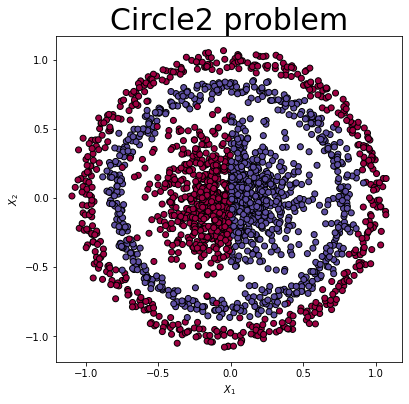

In [429]:
import sklearn
X,y = sklearn.datasets.make_circles(n_samples = N_SAMPLES, noise=0.04, random_state=100)

rng = np.random.RandomState(0)
X_in = rng.randn(1000, 2)/4
y_in = np.zeros(X_in.shape[0])
y_in[(X_in[:,0]>0)]=1
X = np.vstack((X,X_in))
y = np.hstack((y,y_in))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X = X.T
X_train = X_train.T
X_test = X_test.T

y = y.T
y_train = y_train.T
y_test = y_test.T

make_plot(X.T, y.T, 'Circle2 problem')


In [391]:
# 0.695, 0.72333
NN_ARCHITECTURE =  [
        {"N":0, "Name":"input",  "input_dim": None,  "output_dim": 2, "activation": ""},
        {"N":1, "Name":"hiden1", "input_dim": 2,  "output_dim": 25, "activation": "tanh"},
        {"N":2, "Name":"hiden2", "input_dim": 25, "output_dim": 50, "activation": "relu"},
        {"N":3, "Name":"hiden3", "input_dim": 50, "output_dim": 50, "activation": "tanh"},
        {"N":4, "Name":"hiden4", "input_dim": 50, "output_dim": 50, "activation": "relu"},
        {"N":5, "Name":"hiden5", "input_dim": 50, "output_dim": 25, "activation": "tanh"},
        {"N":6, "Name":"output", "input_dim": 25, "output_dim": 1,  "activation": "sigmoid"}
      ]

In [430]:
# 0.99, 0.98556
NN_ARCHITECTURE =  [
        {"N":0, "Name":"input",  "input_dim": None,  "output_dim": 2, "activation": ""},
        {"N":1, "Name":"hiden1", "input_dim": 2,  "output_dim": 25, "activation": "tanh"},
        {"N":2, "Name":"hiden2", "input_dim": 25,  "output_dim": 25, "activation": "relu"},
        {"N":3, "Name":"output", "input_dim": 25, "output_dim": 1,  "activation": "sigmoid"}
      ]

In [431]:
params_values, nOfLayers = init_layers(nn_architecture = NN_ARCHITECTURE)
print(params_values.keys())

dict_keys(['W1', 'b1', 'activation1', 'W2', 'b2', 'activation2', 'W3', 'b3', 'activation3'])


In [438]:
y_y = np.transpose(y_train.reshape((y_train.shape[0], 1)))
print(y_y.shape)
# Training
params_values = train((X_train), y_y, NN_ARCHITECTURE, 5000, 0.1, True)

(1, 1800)
Iteration: 000 - loss: 449.89931 - accuracy: 0.47333
Iteration: 500 - loss: 424.77854 - accuracy: 0.70389
Iteration: 1000 - loss: 406.93090 - accuracy: 0.68667
Iteration: 1500 - loss: 386.64747 - accuracy: 0.70444
Iteration: 2000 - loss: 362.62118 - accuracy: 0.72333
Iteration: 2500 - loss: 305.46393 - accuracy: 0.77722
Iteration: 3000 - loss: 242.69199 - accuracy: 0.84000
Iteration: 3500 - loss: 197.62704 - accuracy: 0.86000
Iteration: 4000 - loss: 174.26178 - accuracy: 0.86111
Iteration: 4500 - loss: 187.55137 - accuracy: 0.87389


In [439]:
Y_hat = predict(X_test, params_values, nOfLayers)
print(Y_hat.shape)
print(get_accuracy_value(Y_hat, y_test))

(1, 200)
0.865


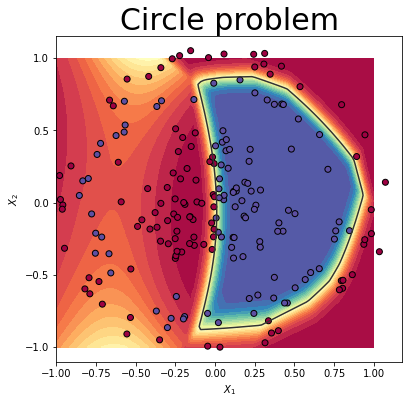

In [440]:
plot_title = "Circle problem"

# boundary of the graph
GRID_X_START = -1
GRID_X_END = 1
GRID_Y_START = -1
GRID_Y_END = 1

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
prediction_probs = predict(grid_2d.T, params_values, len(NN_ARCHITECTURE)-1)
prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
make_plot(X_test.T, y_test.T, plot_title, XX=XX, YY=YY, preds=prediction_probs)

## ADVANCED (необязательные здадания)

### Реализовать стохастический градиентный спуск по минибатчам



 ### Добавить в сеть процедуру ранней остановки по валидационным выборкам

#### Добавить в сеть инициализацию Ге для слоев с ReLU и инициализацию Хавьера для слоев с сигмоидом


### 5  Релизовать метод Adgrad или иной адаптивный метод градиентного спуска (Addelta, adam, admax) 

см. подсказку тут https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/04_optimizers/Optimizers.ipynb

п.с. минибатчи там реализованы не верно, их не смотрите

### 6  добавить в сеть регуляризацию L2 